In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
# 약 20600개의 샘플로 이루어진 데이터 셋
# 9개의 컬럼(target컬럼 포함)
# 배치 사이즈가 20600개인 상테에서 SGD 수행
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns = california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


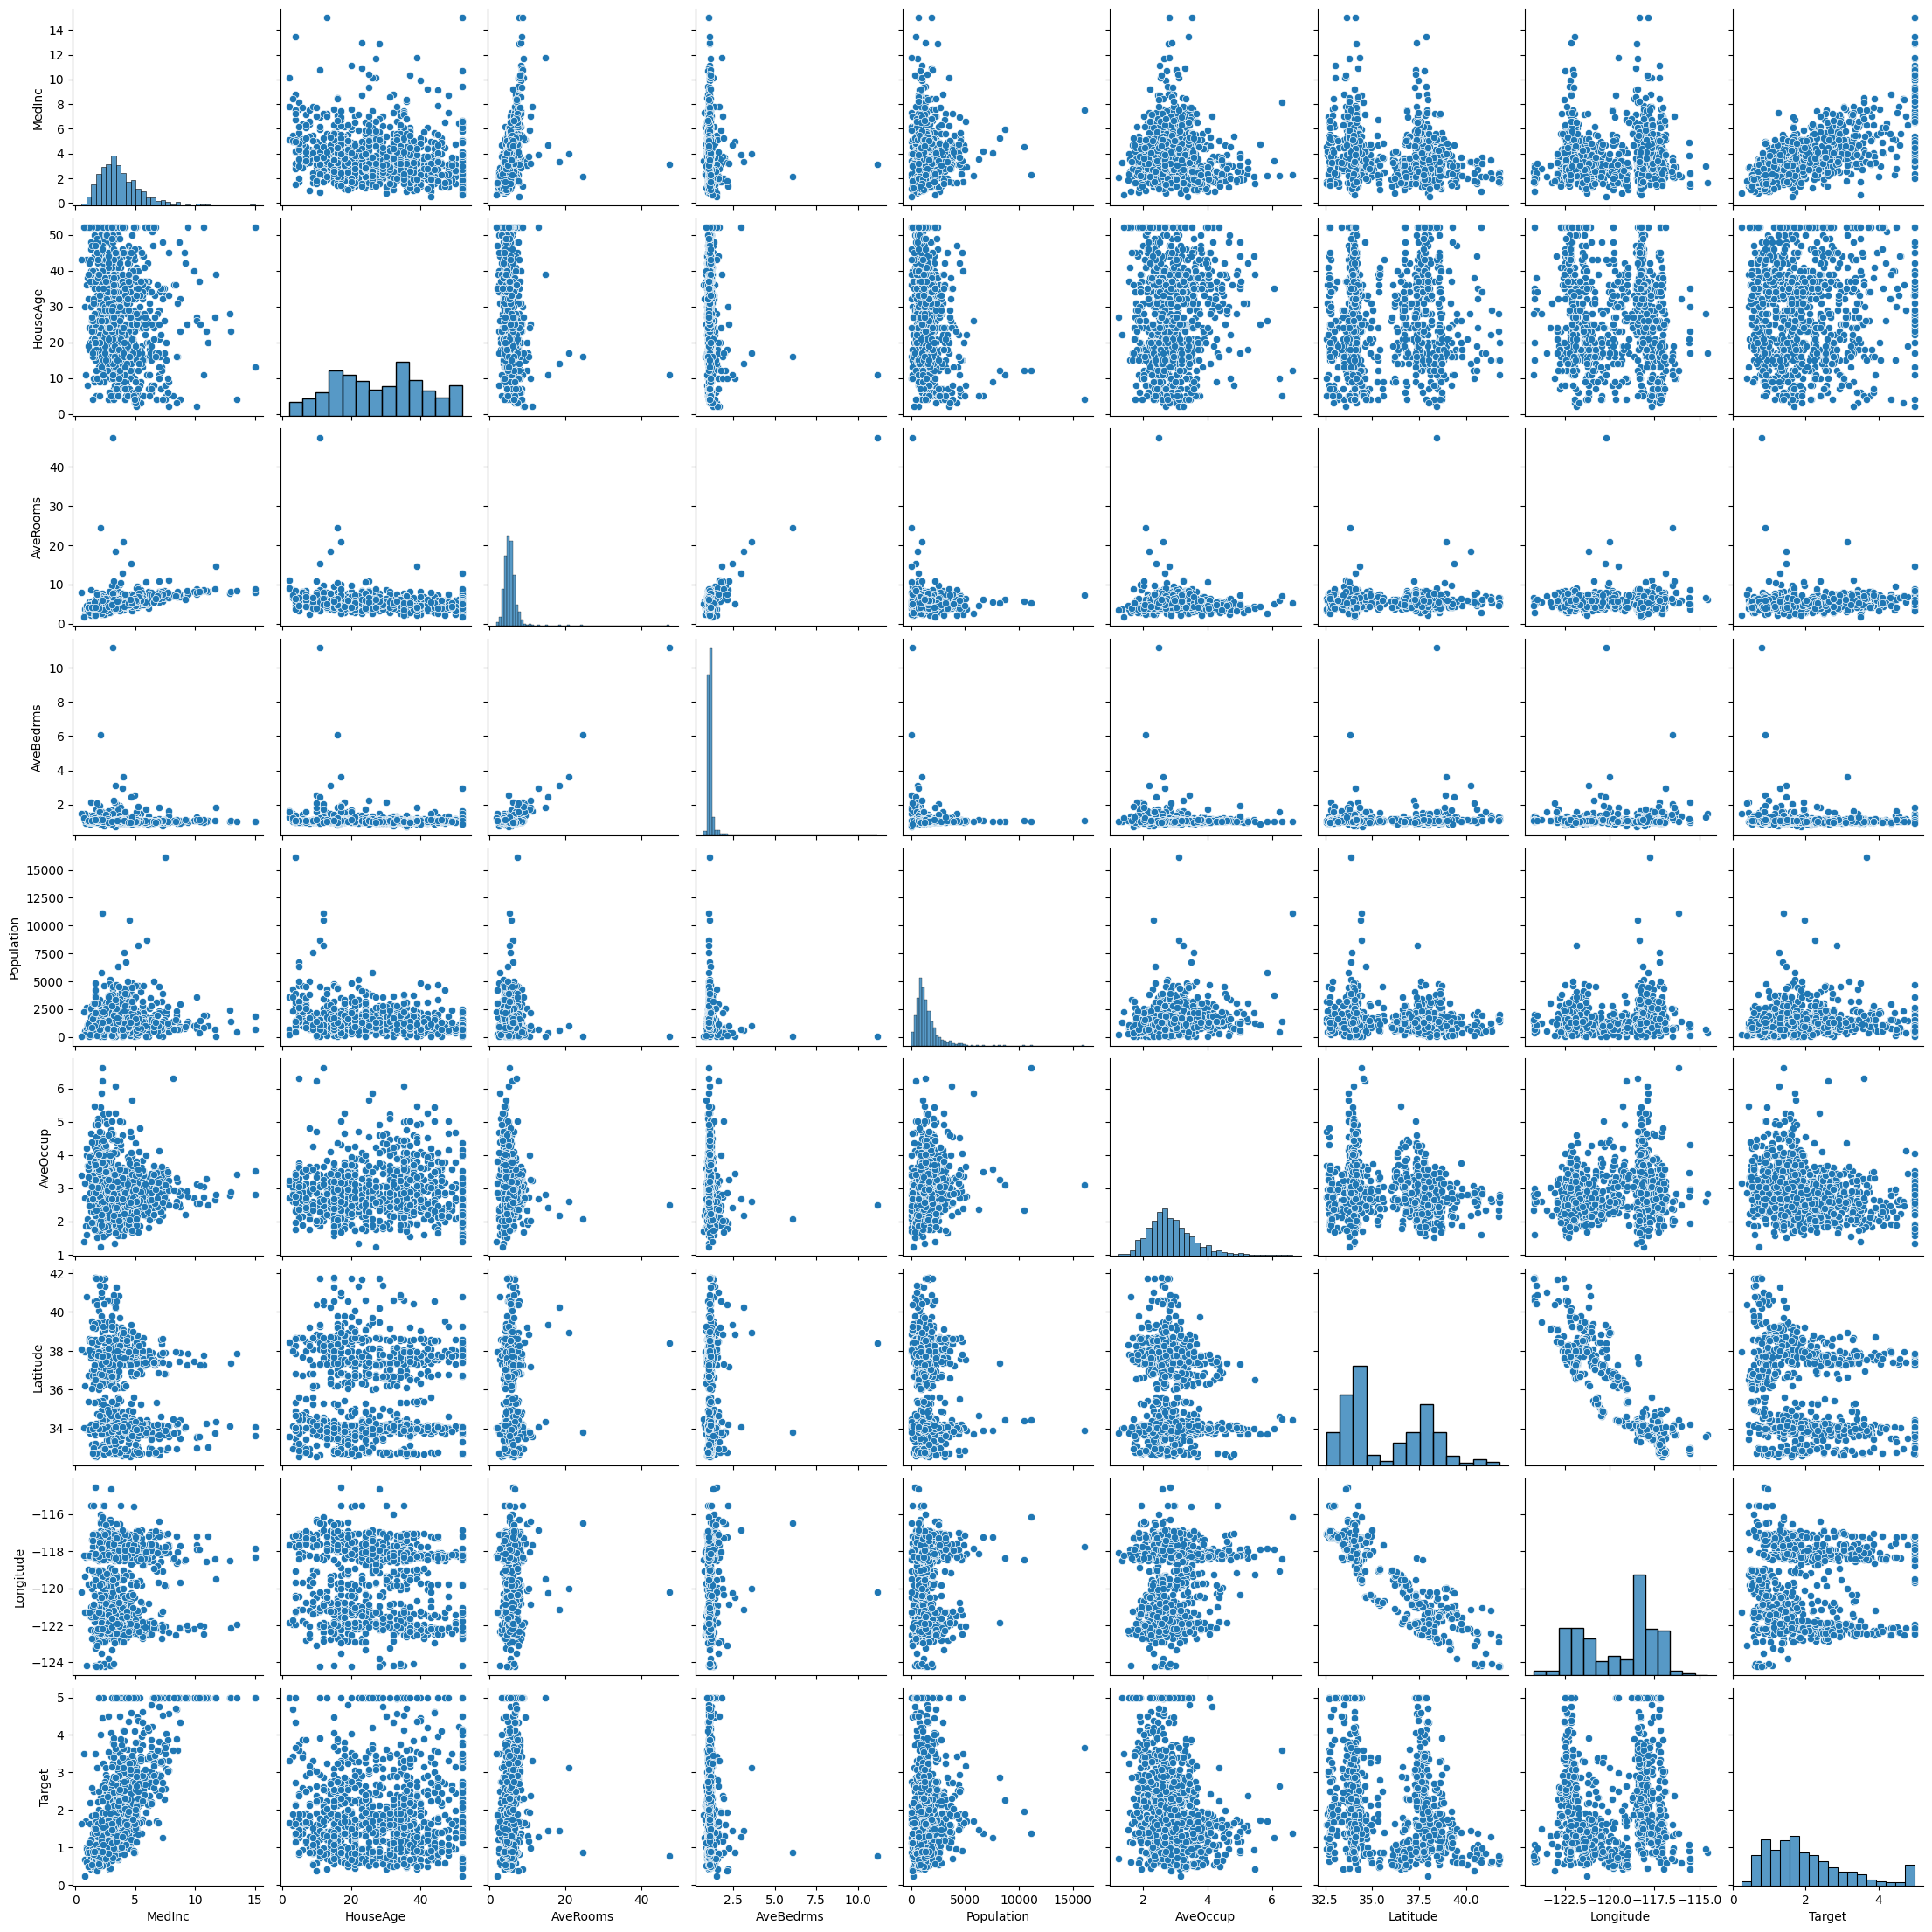

In [5]:
sns.pairplot(df.sample(1000))

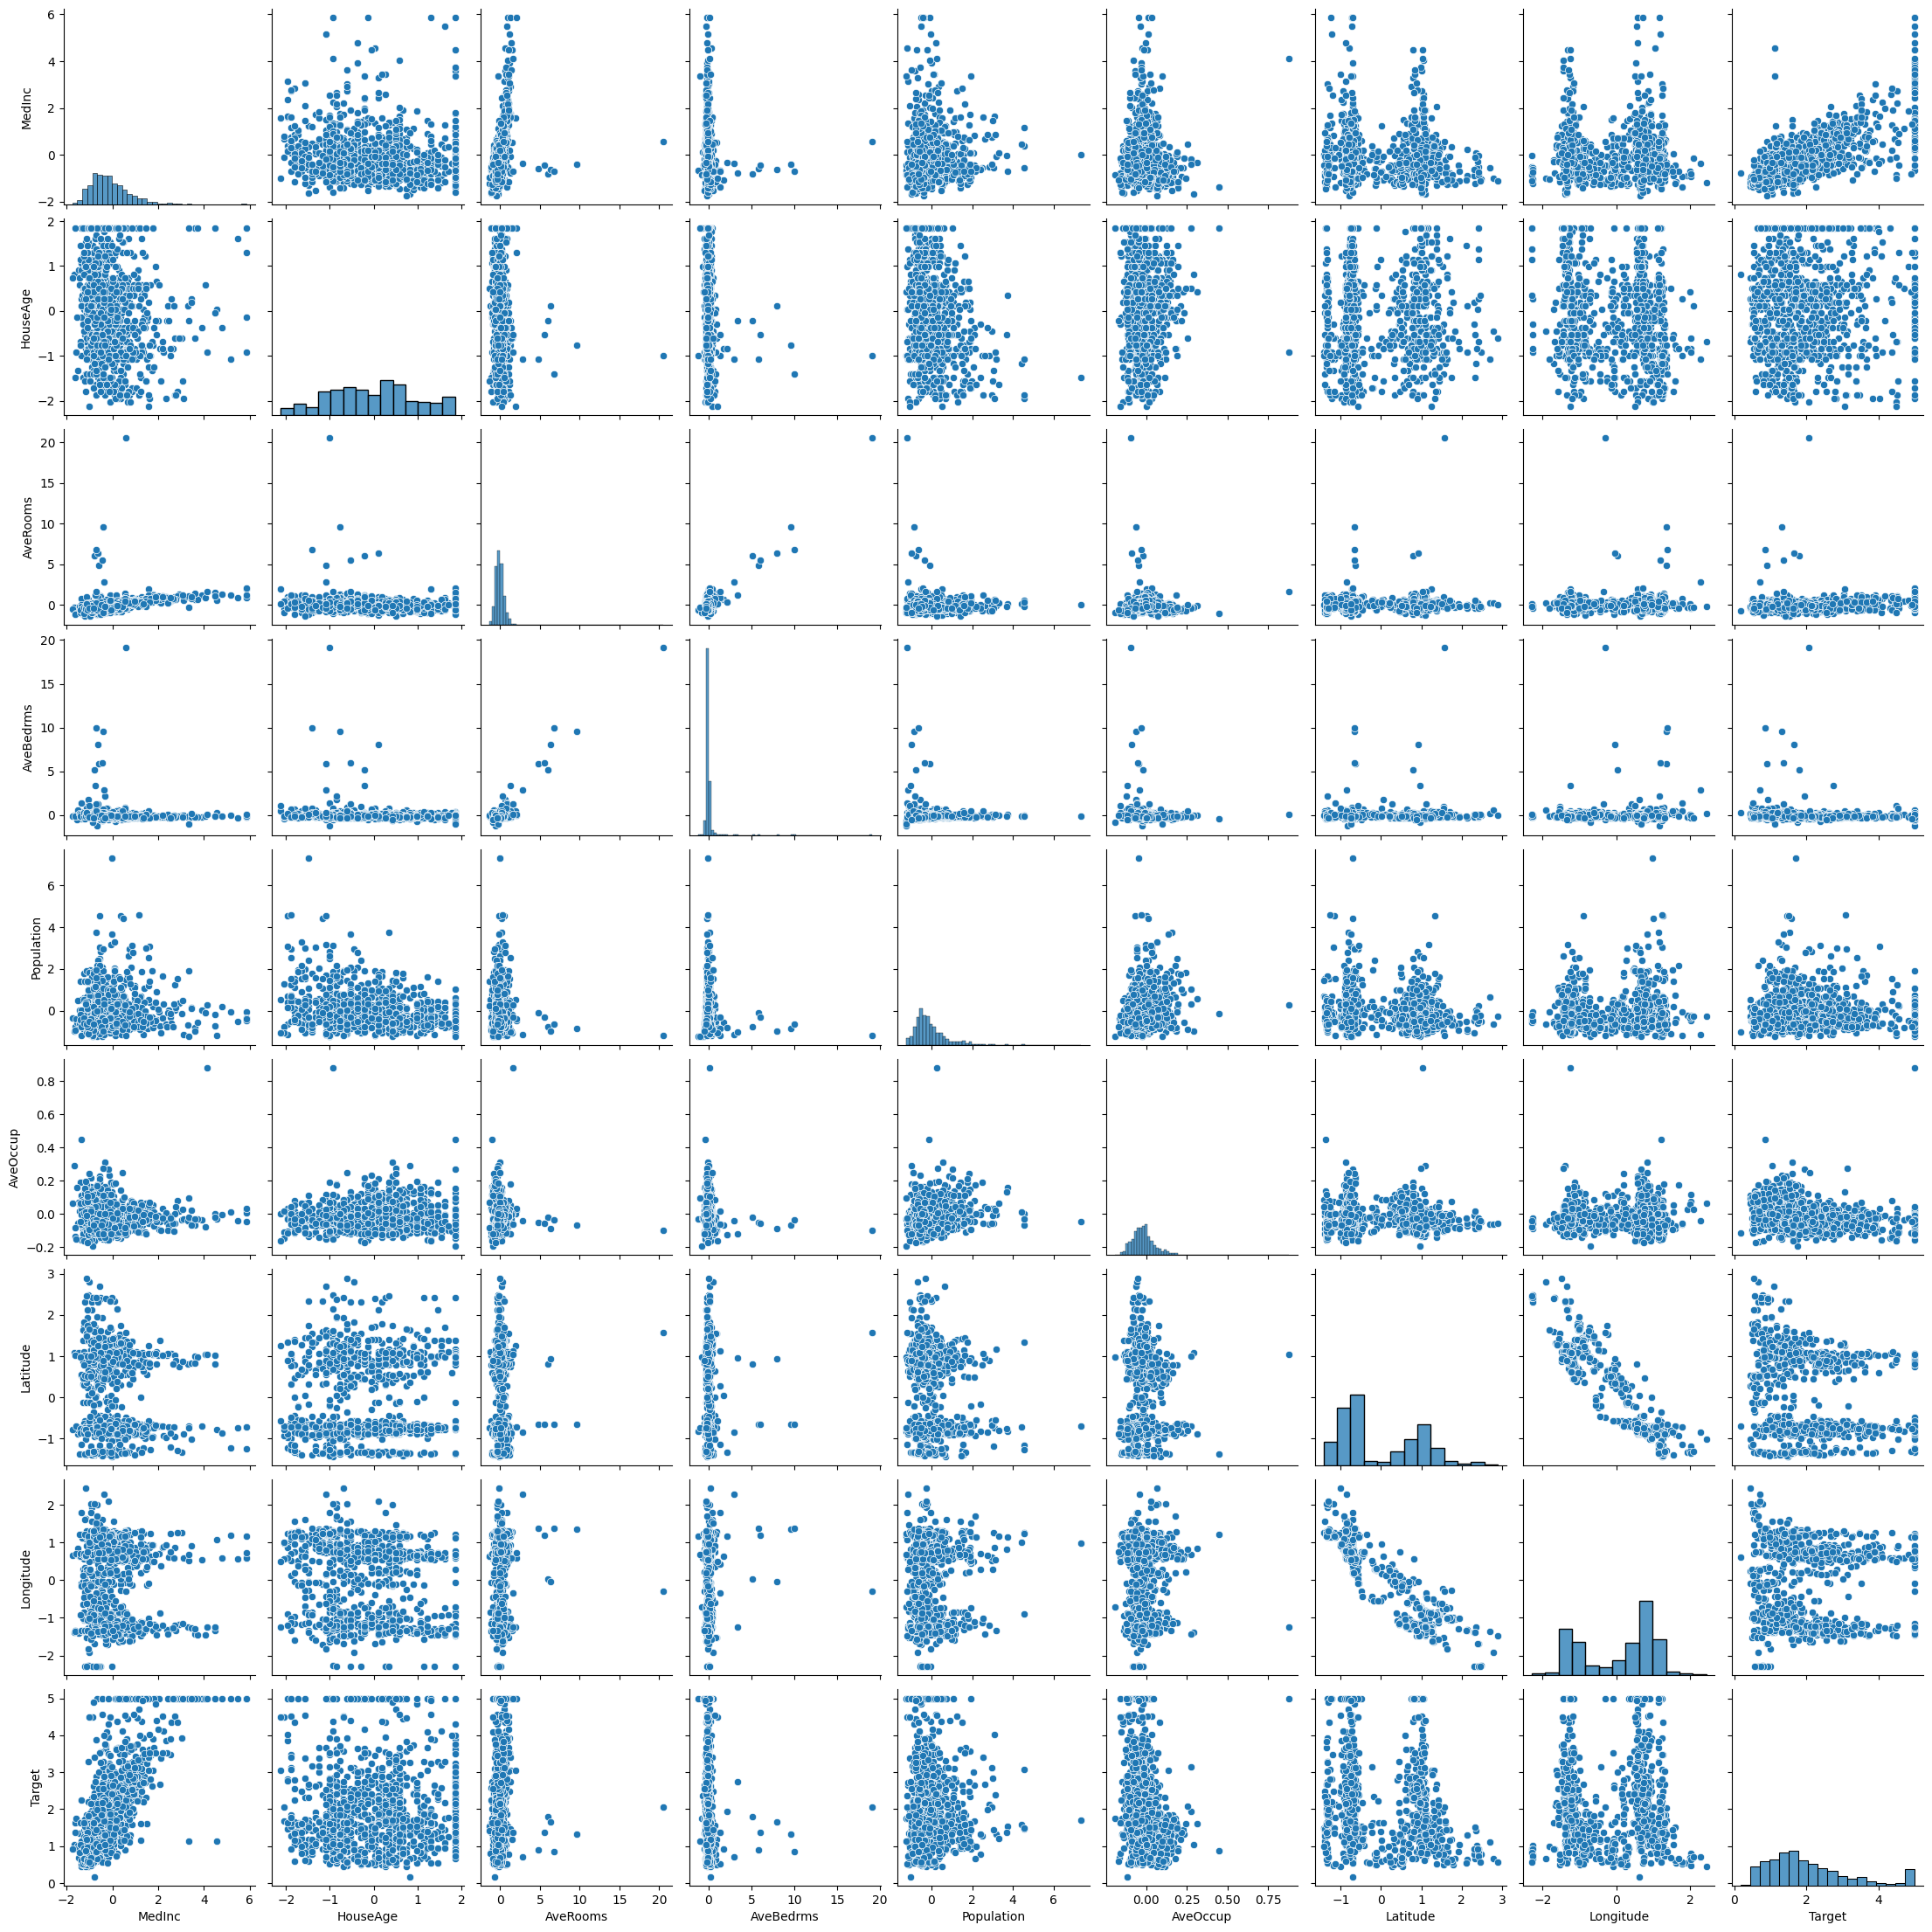

In [6]:
# 데이터 정규화
scaler = StandardScaler()
scaler.fit(df.values[:,:-1])
df.iloc[:,:-1] = scaler.transform(df.values[:,:-1]).round(4)

sns.pairplot(df.sample(1000))
plt.show()

In [20]:
# 학습코드 구현
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
data = torch.from_numpy(df.values).float()

print(data.shape)

torch.Size([20640, 9])


In [22]:
x = data[:,:-1]
y = data[:,-1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [23]:
# 하이퍼 파라미터 설정
n_epochs = 4000
batch_size = 256 # 미니배치 사이즈
print_interval = 200
learning_rate = 1e-2

In [24]:
# 심층신경망 정의
model = nn.Sequential(
    nn.Linear(x.size(-1),6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3,y.size(-1)),
)

print(model)
    

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [25]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [1]:
import time
start = time.time()
for i in range(n_epochs):
    indices = torch.randperm(x.size(0)) # 데이터 샘플 개수를 랜덤하게 섞어서 텐서로 저장 (indices = tensor([7, 2, 9, 0, 5, 1, 4, 8, 3, 6]) 이런식)

    # 데이터 재배열
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)

    # 미니배치 사이즈로 나누어 튜플 형태로 저장(각 요소는 텐서임)
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = [] # 예측값 저장 리스트 초기화 시켜놓음
    total_loss = 0 # 최종 손실 값 저장 변수 초기화 시켜놓음

    # 각 미니배치 별로 손실 값을 구하여 y_hat[]과 total_loss에 저장
    for x_i, y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # loss는 단순한 숫자가 아니라 연산 그래프가 붙어있는 텐서임(tensor(0.5234, grad_fn=<MseLossBackward> 이런식임). 
        # 따라서 float()로 감싸서 메모리 손실을 없앰
        total_loss += float(loss)

        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_) # 미니배치의 크기로 나누어 최종 손실 값의 평균을 구함
    if(i+1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i+1, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

end = time.time()
elapsed = end - start
print('Elapsed time: %dm %ds'%(elapsed//60, int(elapsed - elapsed//60)))

NameError: name 'n_epochs' is not defined